In [64]:
from poloniex import Poloniex
polo = Poloniex()
import os, datetime
import matplotlib.pyplot as plt
%matplotlib inline
import plotly_express as px
import datetime

#input date time and Symbol
now = datetime.datetime.now()
startdate = '1/11/2010'
end_date= now.strftime("%d/%m/%Y")
Symbol = 'USDT_BTC'

#Set the time period to use. time categories: 7200, 14400, and 86400(daily).
timeperiod = 7200

#set the moving averages to use. MA = Simple Moving Average and EMA = Exponential Moving Average
MA1 = 10
MA2 = 20
EMA1 = 10
EMA2 = 20
#Create MA Variables
MA1_var = 'MA'+str(MA1)
MA2_var = 'MA'+str(MA2)
EMA1_var = 'EMA'+str(EMA1)
EMA2_var = 'EMA'+str(EMA2)


#pull HISTORICAL DATA
#86400 denotes daily
import pandas as pd
Daily_data =polo.returnChartData(Symbol, timeperiod, start= datetime.datetime.strptime(startdate, "%d/%m/%Y").timestamp(), end= datetime.datetime.strptime(end_date, "%d/%m/%Y").timestamp())
Daily_data = pd.DataFrame(Daily_data)
Daily_data['True Date']= pd.to_datetime(Daily_data['date'], unit='s')
Daily_data['Year']=  Daily_data['True Date'].dt.year

#moving average columns
Daily_data[MA1_var] = Daily_data['close'].rolling(MA1).mean()
Daily_data[MA2_var] = Daily_data['close'].rolling(MA2).mean()
Daily_data[EMA1_var] = Daily_data['close'].ewm(span = EMA1).mean()
Daily_data[EMA2_var] = Daily_data['close'].ewm(span = EMA2).mean()

#Rules
#Shorter moving average crosses over longer. Buy at closing price Logic Buy = Short>Long or SELL = Short<Long
#The strategy will always be long or short.
#Use closing prices as entry points
#Profit/Loss -- For buy (10>50) profit = close on day of cross until until 10<50 Reversal.
#Profit/Loss -- For Sell this is the reverse

Daily_data.head(2)


,close,date,high,low,open,quoteVolume,volume,weightedAverage,True Date,Year,MA10,MA20,EMA10,EMA20
0,225.0,1424368800,225.0,225.0,225.0,0.004444,0.999999,225.000000,2015-02-19 18:00:00,2015,NaN,NaN,225.00,225.000
1,244.0,1424376000,244.0,225.0,225.0,0.188671,45.275877,239.972316,2015-02-19 20:00:00,2015,NaN,NaN,235.45,234.975


In [65]:
#drop the Nan to get to the start of the moving averages
Daily_data_SMA= Daily_data.dropna()
Daily_data_SMA.head(2)

,close,date,high,low,open,quoteVolume,volume,weightedAverage,True Date,Year,MA10,MA20,EMA10,EMA20
19,240.25,1424505600,240.25,240.25,240.25,0.0,0.0,240.25,2015-02-21 08:00:00,2015,240.25,240.662506,240.412493,240.577093
20,240.25,1424512800,240.25,240.25,240.25,0.0,0.0,240.25,2015-02-21 10:00:00,2015,240.25,241.425006,240.382506,240.541603


In [66]:
#create the long/short column:
# We create a function to loop through each row and assess whether the current trade is either Long or Short

def buy_sell (row):
   if row[MA1_var] > row[MA2_var] :
      return 'LONG'
   if row[MA1_var] < row[MA2_var] :
      return 'SHORT'    
longshort = Daily_data.apply (lambda row: buy_sell(row), axis=1)
Daily_data_SMA['Go Long or Short'] = longshort
Daily_data_SMA.head(2)

C:\Users\jthor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,close,date,high,low,open,quoteVolume,volume,weightedAverage,True Date,Year,MA10,MA20,EMA10,EMA20,Go Long or Short
19,240.25,1424505600,240.25,240.25,240.25,0.0,0.0,240.25,2015-02-21 08:00:00,2015,240.25,240.662506,240.412493,240.577093,SHORT
20,240.25,1424512800,240.25,240.25,240.25,0.0,0.0,240.25,2015-02-21 10:00:00,2015,240.25,241.425006,240.382506,240.541603,SHORT


In [67]:
#Find where the column values change
#this function compares current value to previous value and if they are the same = True
#If current value does not equal then it is false.
#Therefore all the "false" tags will have an exit price for our long and a entry price for our short
Daily_data_SMA['SMA entry and exit'] = Daily_data_SMA['Go Long or Short'].eq(Daily_data_SMA['Go Long or Short'].shift())
Daily_data_SMA.head(2)

C:\Users\jthor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,close,date,high,low,open,quoteVolume,volume,weightedAverage,True Date,Year,MA10,MA20,EMA10,EMA20,Go Long or Short,SMA entry and exit
19,240.25,1424505600,240.25,240.25,240.25,0.0,0.0,240.25,2015-02-21 08:00:00,2015,240.25,240.662506,240.412493,240.577093,SHORT,False
20,240.25,1424512800,240.25,240.25,240.25,0.0,0.0,240.25,2015-02-21 10:00:00,2015,240.25,241.425006,240.382506,240.541603,SHORT,True


In [68]:
#Lets pull out all the entry and exit points with closing price and Short or long column
EntryandExit = Daily_data_SMA.loc[Daily_data_SMA['SMA entry and exit'] == False]
EntryandExit
#NEXT Calculate the profit/Loss per trade
#Step 1 Change all the rows named SHORT to Negative
EntryandExit.loc[EntryandExit['Go Long or Short'] == 'LONG', 'close'] = EntryandExit['close']*-1
#Calculate the profit or loss on the trades. Fist column will be nan after that the profit or 
#loss is calculated on a per trade basis

#EntryandExit['Running Total'] = EntryandExit['Profit or Loss'].cumsum()
EntryandExit['SMA Profit or Loss'] =  EntryandExit.close+EntryandExit.close.shift(1) 
#Cumulative Profit or loss
EntryandExit['SMA Cumulative Profit or Loss'] =  EntryandExit['SMA Profit or Loss'].cumsum()

EntryandExit.head(2)

C:\Users\jthor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\jthor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,close,date,high,low,open,quoteVolume,volume,weightedAverage,True Date,Year,MA10,MA20,EMA10,EMA20,Go Long or Short,SMA entry and exit,SMA Profit or Loss,SMA Cumulative Profit or Loss
19,240.25,1424505600,240.25,240.25,240.25,0.0,0.0,240.25,2015-02-21 08:00:00,2015,240.25,240.662506,240.412493,240.577093,SHORT,False,NaN,NaN
25,-245.00,1424548800,245.00,245.00,245.00,0.0,0.0,245.00,2015-02-21 20:00:00,2015,241.20,240.962506,241.876932,241.348253,LONG,False,-4.75,-4.75


In [69]:
#trade statistics
total_trades_sma= len(EntryandExit)
Total_profit_points_sma = EntryandExit['SMA Profit or Loss'].sum()
largest_drawdown_sma = EntryandExit['SMA Profit or Loss'].min()
largest_winner_sma = EntryandExit['SMA Profit or Loss'].max()

In [70]:
#Group by to get profit or loss per year
profit_by_year = EntryandExit[['Year','SMA Profit or Loss']]
profit_by_year.groupby(['Year']).sum()


,SMA Profit or Loss
Year,
2015,-653.224638
2016,23.519519
2017,17584.257543
2018,7431.272562
2019,-599.146597


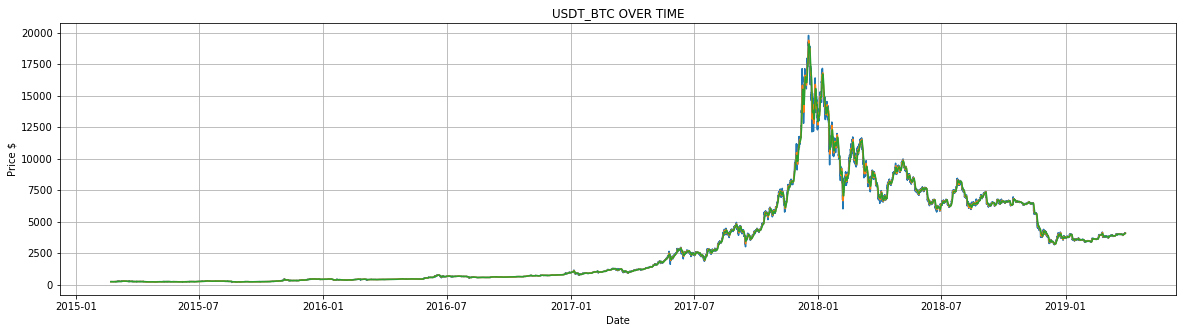

In [71]:
#Plot price and moving averages
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,5)) 
plt.plot(Daily_data_SMA['True Date'], Daily_data_SMA['close'])
plt.plot(Daily_data_SMA['True Date'], Daily_data_SMA[MA1_var])
plt.plot(Daily_data_SMA['True Date'], Daily_data_SMA[MA2_var])

# Incorporate the other graph properties
plt.title(f"{Symbol} OVER TIME")
plt.ylabel("Price $")
plt.xlabel("Date")
plt.grid(True)

# Save the figure
#plt.savefig("Latitude_vs_Wind.png")

# Show plot
plt.show()


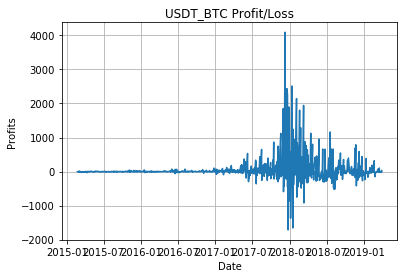

In [72]:
#Plot profit line
import matplotlib.pyplot as plt
plt.plot(EntryandExit['True Date'], EntryandExit['SMA Profit or Loss'])

# Incorporate the other graph properties
plt.title(f"{Symbol} Profit/Loss")
plt.ylabel("Profits")
plt.xlabel("Date")
plt.grid(True)

# Save the figure
#plt.savefig("Latitude_vs_Wind.png")

# Show plot
plt.show()

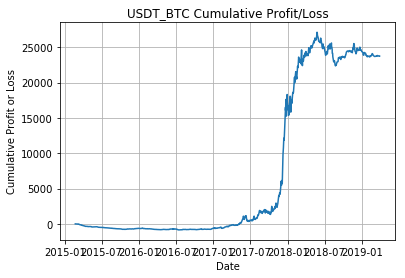

In [73]:
#Plot cummulative Profit /Loss
#Plot profit line
import matplotlib.pyplot as plt
plt.plot(EntryandExit['True Date'], EntryandExit['SMA Cumulative Profit or Loss'])

# Incorporate the other graph properties
plt.title(f"{Symbol} Cumulative Profit/Loss")
plt.ylabel("Cumulative Profit or Loss")
plt.xlabel("Date")
plt.grid(True)

# Save the figure
#plt.savefig("Latitude_vs_Wind.png")

# Show plot
plt.show()

Start of Second Strategy: Exponential Moving average

In [74]:
#drop the Nan to get to the start of the moving averages
Daily_data_EMA= Daily_data.dropna()

In [75]:
#create the long/short column:
def buy_sell (row):
   if row[EMA1_var] > row[EMA2_var] :
      return 'LONG'
   if row[EMA1_var] < row[EMA2_var] :
      return 'SHORT'    
longshort = Daily_data.apply (lambda row: buy_sell(row), axis=1)
Daily_data_EMA['EMA Go Long or Short'] = longshort
Daily_data_EMA.head(2)

C:\Users\jthor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,close,date,high,low,open,quoteVolume,volume,weightedAverage,True Date,Year,MA10,MA20,EMA10,EMA20,EMA Go Long or Short
19,240.25,1424505600,240.25,240.25,240.25,0.0,0.0,240.25,2015-02-21 08:00:00,2015,240.25,240.662506,240.412493,240.577093,SHORT
20,240.25,1424512800,240.25,240.25,240.25,0.0,0.0,240.25,2015-02-21 10:00:00,2015,240.25,241.425006,240.382506,240.541603,SHORT


In [76]:
#Find where the column values change
#this function compares current value to previous value and if they are the same = True
#If current value does not equal then it is false.
#Therefore all the "false" tags will have an exit price for our long and a entry price for our short
Daily_data_EMA['EMA entry and exit'] = Daily_data_EMA['EMA Go Long or Short'].eq(Daily_data_EMA['EMA Go Long or Short'].shift())
Daily_data_EMA.to_csv('ema_output.csv')
Daily_data_EMA.head(2)

C:\Users\jthor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,close,date,high,low,open,quoteVolume,volume,weightedAverage,True Date,Year,MA10,MA20,EMA10,EMA20,EMA Go Long or Short,EMA entry and exit
19,240.25,1424505600,240.25,240.25,240.25,0.0,0.0,240.25,2015-02-21 08:00:00,2015,240.25,240.662506,240.412493,240.577093,SHORT,False
20,240.25,1424512800,240.25,240.25,240.25,0.0,0.0,240.25,2015-02-21 10:00:00,2015,240.25,241.425006,240.382506,240.541603,SHORT,True


In [77]:
#Lets pull out all the entry and exit points with closing price and Short or long column
EntryandExit = Daily_data_EMA.loc[Daily_data_EMA['EMA entry and exit'] == False]
EntryandExit
#NEXT Calculate the profit/Loss per trade
#Step 1 Change all the rows named SHORT to Negative
EntryandExit.loc[EntryandExit['EMA Go Long or Short'] == 'LONG', 'close'] = EntryandExit['close']*-1
#Calculate the profit or loss on the trades. Fist column will be nan after that the profit or 
#loss is calculated on a per trade basis

#EntryandExit['Running Total'] = EntryandExit['Profit or Loss'].cumsum()
EntryandExit['EMA Profit or Loss'] =  EntryandExit.close+EntryandExit.close.shift(1) 
#Cumulative Profit or loss
EntryandExit['EMA Cumulative Profit or Loss'] =  EntryandExit['EMA Profit or Loss'].cumsum()
EntryandExit.head(2)

C:\Users\jthor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\jthor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,close,date,high,low,open,quoteVolume,volume,weightedAverage,True Date,Year,MA10,MA20,EMA10,EMA20,EMA Go Long or Short,EMA entry and exit,EMA Profit or Loss,EMA Cumulative Profit or Loss
19,240.25,1424505600,240.25,240.25,240.25,0.000000,0.000000,240.25,2015-02-21 08:00:00,2015,240.250,240.662506,240.412493,240.577093,SHORT,False,NaN,NaN
24,-245.00,1424541600,245.00,245.00,245.00,0.060091,14.722239,245.00,2015-02-21 18:00:00,2015,240.725,240.912506,241.178288,240.929562,LONG,False,-4.75,-4.75


In [78]:
#trade statistics
total_trades_ema= len(EntryandExit)
Total_profit_points_ema = EntryandExit['EMA Profit or Loss'].sum()
largest_drawdown_ema = EntryandExit['EMA Profit or Loss'].min()
largest_winner_ema = EntryandExit['EMA Profit or Loss'].max()

In [79]:
#Group by to get profit or loss per year
profit_by_year = EntryandExit[['Year','EMA Profit or Loss']]
profit_by_year.groupby(['Year']).sum()


,EMA Profit or Loss
Year,
2015,-1496.349679
2016,-204.055346
2017,15581.838419
2018,14633.980439
2019,-534.912719


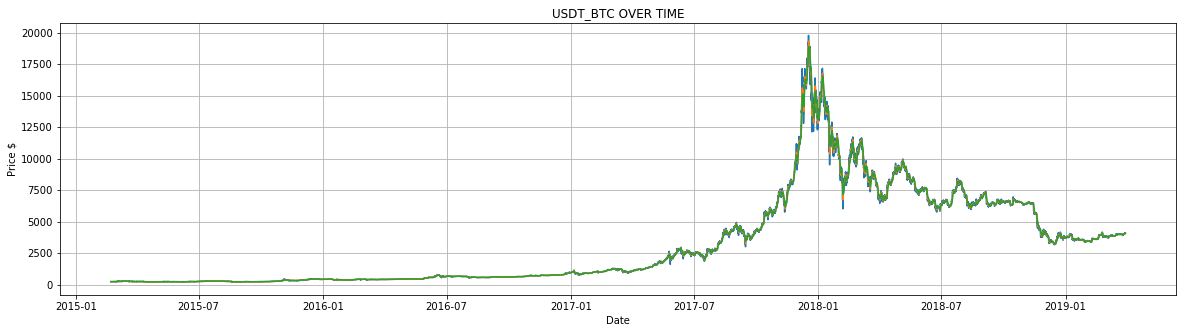

In [80]:
#Plot price and moving averages
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,5)) 
plt.plot(Daily_data_EMA['True Date'], Daily_data_EMA['close'])
plt.plot(Daily_data_EMA['True Date'], Daily_data_EMA[EMA1_var])
plt.plot(Daily_data_EMA['True Date'], Daily_data_EMA[EMA2_var])

# Incorporate the other graph properties
plt.title(f"{Symbol} OVER TIME")
plt.ylabel("Price $")
plt.xlabel("Date")
plt.grid(True)

# Show plot
plt.show()

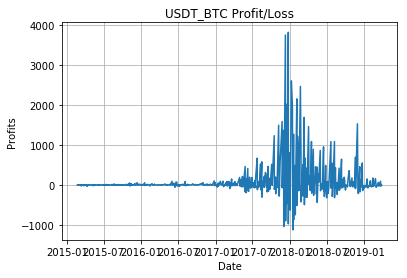

<Figure size 2160x2880 with 0 Axes>

In [81]:
#Plot profit line
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(EntryandExit['True Date'], EntryandExit['EMA Profit or Loss'])

# Incorporate the other graph properties
plt.title(f"{Symbol} Profit/Loss")
plt.ylabel("Profits")
plt.xlabel("Date")
plt.grid(True)
plt.figure(figsize=(30,40))

# Show plot
plt.show()

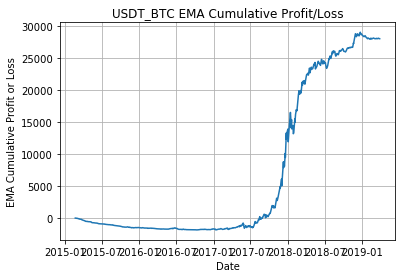

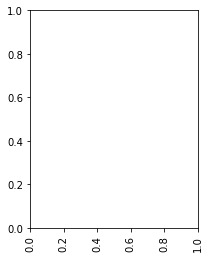

In [82]:
#Plot cummulative Profit /Loss
#Plot profit line
import matplotlib.pyplot as plt

plt.plot(EntryandExit['True Date'], EntryandExit['EMA Cumulative Profit or Loss'])

# Incorporate the other graph properties

plt.title(f"{Symbol} EMA Cumulative Profit/Loss")
plt.ylabel("EMA Cumulative Profit or Loss")
plt.xlabel("Date")
plt.grid(True)
plt.figure(figsize=(3,4))

plt.xticks(rotation=90)
# Save the figure

# Show plot
plt.show()

Comparison of Strategies -- Charts and Output

In [83]:

print(f"There were {total_trades_sma} trades made for the Simple Moving Average Strategy. The Total Profit/Loss from the \
strategy was ${round(Total_profit_points_sma,2)}. The largest single winner was ${round(largest_winner_sma,2)} and the largest drawdown was ${round(largest_drawdown_sma,2)}")

There were 1068 trades made for the Simple Moving Average Strategy. The Total Profit/Loss from the strategy was $23786.68. The largest single winner was $4092.68 and the largest drawdown was $-1713.89


In [84]:

print(f"There were {total_trades_ema} trades made for the Exponential Moving Average Strategy. The Total Profit/Loss from the \
strategy was ${round(Total_profit_points_ema,2)}. The largest single winner was ${round(largest_winner_ema,2)} and the largest drawdown was ${round(largest_drawdown_ema,2)}")

There were 862 trades made for the Exponential Moving Average Strategy. The Total Profit/Loss from the strategy was $27980.5. The largest single winner was $3822.02 and the largest drawdown was $-1129.89
